In [1]:
import pandas as pd
import numpy as np
from pylab import rcParams
import matplotlib.pyplot as plt
from pandas.io import sql as sqlio
import sys
import glob
import os
import statsmodels.api as sm
import statsmodels.formula.api as smf
import psycopg2
import gzip
import datetime
import seaborn as sns
import requests
import pickle
import time
import itertools
import scipy
from scipy.stats import norm
from sklearn import preprocessing
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
from pytz import timezone
from statsmodels.tsa.stattools import adfuller
import cvxpy as cp

import os.path as op

# mount google drive
from google.colab import drive
drive.mount('/content/drive')

sys.path.append('/content/drive/My Drive/Internship/Sean_Li/sentiment_analysis/Code/')
import analysis_functions as af

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


/usr/local/lib/python3.6/dist-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


# Load Price Data

In [2]:
print('Reading OKEx Data...')
price_dict = {}
data_path = '/content/drive/My Drive/Internship/Sean_Li/sentiment_analysis/Data/OKEx_S_Data/'
files = os.listdir(data_path)
for i in files:
  coin_name = i[0:i.find('.csv')]
  if coin_name == 'BTC':
    print('Reading ' + coin_name + ' data')
    df = pd.read_csv(data_path + i)
    df['quote_time'] = pd.to_datetime(df['quote_time'])
    df.set_index('quote_time', inplace = True)
    df = df.resample('T').asfreq()
    price_dict.update({coin_name : df.copy()})

Reading OKEx Data...
Reading BTC data


# Load TheTie Data

In [3]:
path_2017 = '/content/drive/My Drive/Internship/Sean_Li/sentiment_analysis/Data/TheTie/FTP_Data/Raw_S-Score/2017/'
path_2018 = '/content/drive/My Drive/Internship/Sean_Li/sentiment_analysis/Data/TheTie/FTP_Data/Raw_S-Score/2018/'
path_2019 = '/content/drive/My Drive/Internship/Sean_Li/sentiment_analysis/Data/TheTie/FTP_Data/Raw_S-Score/2019/'
paths = [path_2017, path_2018, path_2019]
data_dict = {}
for path in paths:
  files = os.listdir(path)
  data_files = []
  for i in files:
    if (i[-5:] == 'X.txt') & (i[0:3] in price_dict.keys()) & (i[3] == '.'):
      data_files.append(i)
  for name in data_files:
    print('\r', 'Reading ' + name, end = '')
    end_ind = name.find('.X.txt')
    coin_name = name[0:end_ind]
    if coin_name in data_dict.keys():
      temp_df = data_dict.get(coin_name)
      read_df = pd.read_csv(path + name, skiprows = 5, delimiter = '\t')
      read_df['date'] = pd.to_datetime(read_df['date'])
      read_df.set_index('date', inplace = True)
      data_dict.update({coin_name: temp_df.append(read_df)})
    else:
      read_df = pd.read_csv(path + name, skiprows = 5, delimiter = '\t')
      read_df['date'] = pd.to_datetime(read_df['date'])
      read_df.set_index('date', inplace = True)
      data_dict.update({coin_name: read_df})

 Reading BTC.X.txt

# Parse Raw Data

In [0]:
BTC_signal = data_dict.get('BTC')
BTC_prices = price_dict.get('BTC')

In [5]:
BTC_df = BTC_prices[['close']].join(BTC_signal[['raw-score']], how = 'inner')
BTC_df

,close,raw-score
2017-10-22 04:40:00,5750.01,0.521
2017-10-22 04:55:00,5750.00,0.497
2017-10-22 05:10:00,5750.00,0.481
2017-10-22 05:25:00,5750.00,0.479
2017-10-22 05:40:00,5879.59,0.450
...,...,...
2019-09-30 22:55:00,8223.20,-1.579
2019-09-30 23:10:00,8229.50,-1.539
2019-09-30 23:25:00,8242.80,-1.536
2019-09-30 23:40:00,8261.20,-1.546


In [6]:
BTC_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 67993 entries, 2017-10-22 04:40:00 to 2019-09-30 23:55:00
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   close      66550 non-null  float64
 1   raw-score  67993 non-null  float64
dtypes: float64(2)
memory usage: 1.6 MB


In [0]:
BTC_df = BTC_df.resample('15T', base = 40).asfreq() # Fill in missing values for calculating 15min returns

In [0]:
BTC_df['Log P'] = np.log(BTC_df['close'])
BTC_df['Log r'] = BTC_df['Log P'].diff().shift(-1)

In [9]:
BTC_df = BTC_df[['Log P', 'Log r', 'raw-score']].copy().dropna()
BTC_df

,Log P,Log r,raw-score
2017-10-22 04:40:00,8.656957,-0.000002,0.521
2017-10-22 04:55:00,8.656955,0.000000,0.497
2017-10-22 05:10:00,8.656955,0.000000,0.481
2017-10-22 05:25:00,8.656955,0.022287,0.479
2017-10-22 05:40:00,8.679242,0.000000,0.450
...,...,...,...
2019-09-30 22:40:00,9.014338,0.000377,-1.595
2019-09-30 22:55:00,9.014715,0.000766,-1.579
2019-09-30 23:10:00,9.015481,0.001615,-1.539
2019-09-30 23:25:00,9.017095,0.002230,-1.536


# Check Raw Data

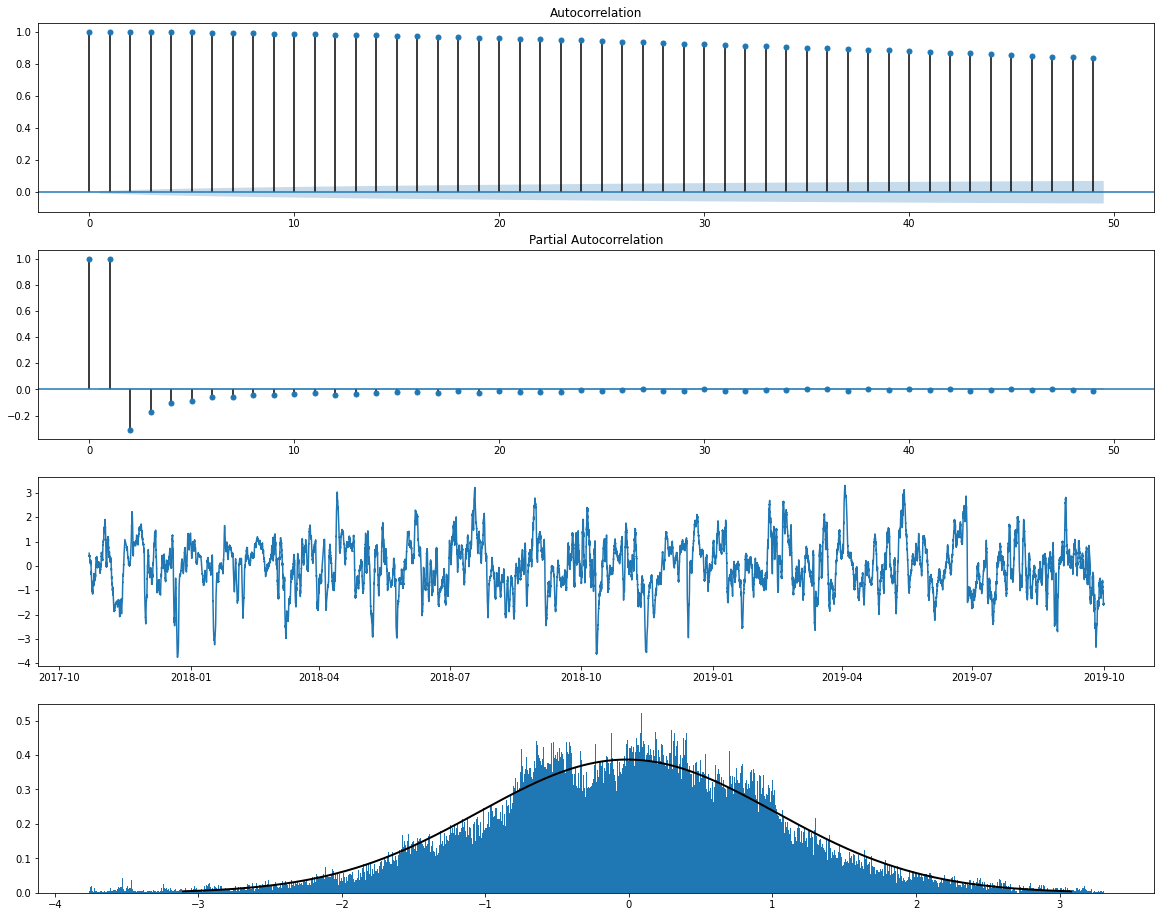

0

In [10]:
af.plot_analysis_plots(BTC_df['raw-score'])

From the ACF, it seems the signal is not stationary with a unit root as shown in the PACF. Histogram looks clean so the data doesn't seem to have extreme outliers

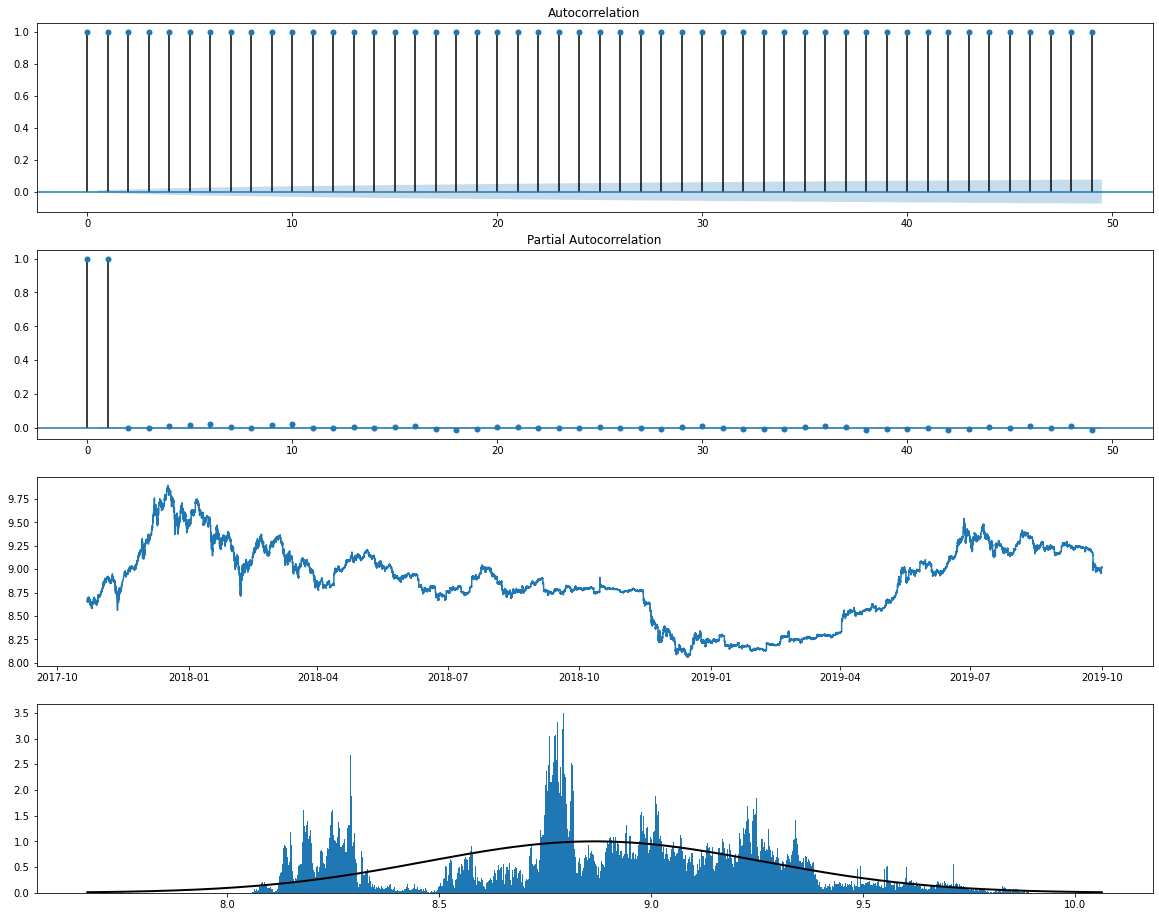

0

In [11]:
af.plot_analysis_plots(BTC_df['Log P'])

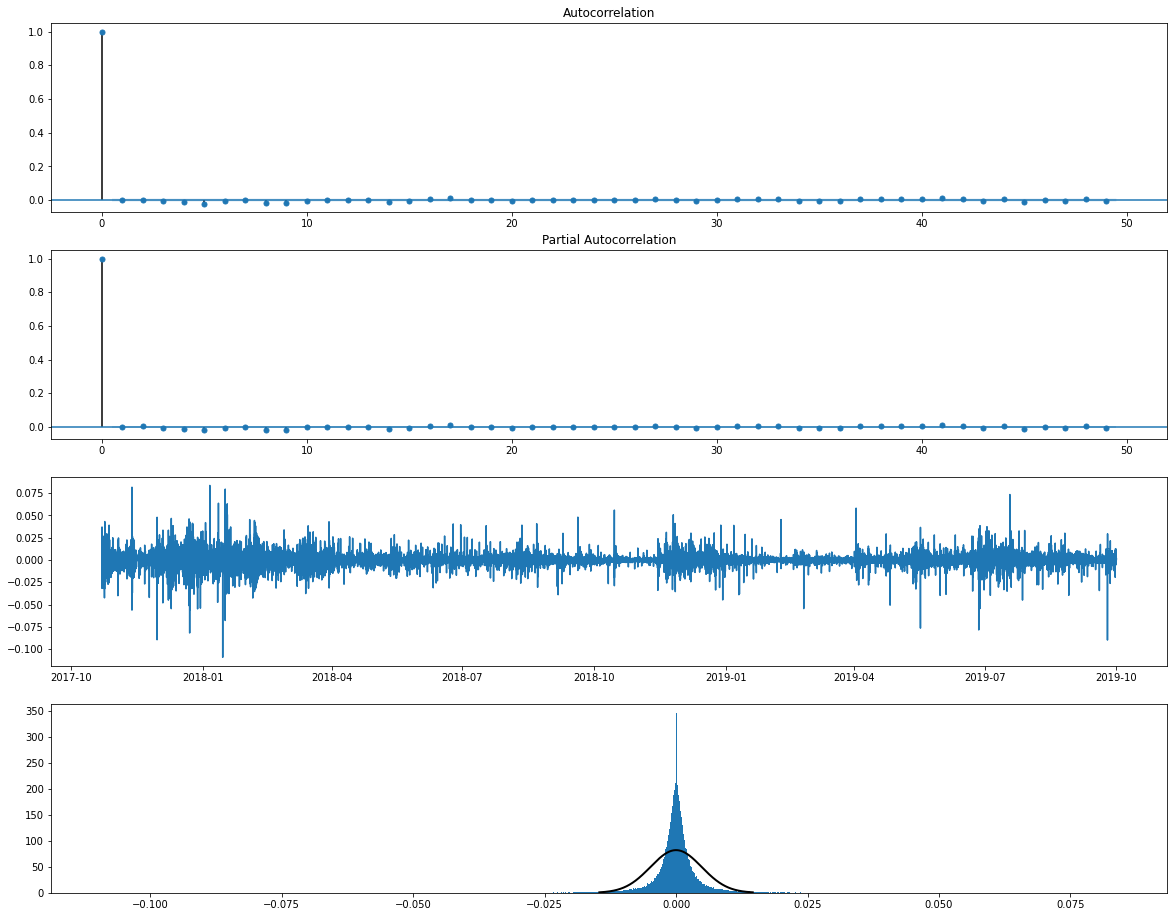

0

In [12]:
af.plot_analysis_plots(BTC_df['Log r'])

Doublechecking BTC prices and returns to make sure they behave similar to stock prices. As expected, the prices are not stationary. 

# Analyze BTC Signal

In [0]:
model = sm.OLS(BTC_df['Log P'], BTC_df['raw-score']).fit()

In [14]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  Log P   R-squared (uncentered):                   0.000
Model:                            OLS   Adj. R-squared (uncentered):              0.000
Method:                 Least Squares   F-statistic:                              11.19
Date:                Tue, 09 Jun 2020   Prob (F-statistic):                    0.000825
Time:                        06:04:04   Log-Likelihood:                     -2.3883e+05
No. Observations:               66303   AIC:                                  4.777e+05
Df Residuals:                   66302   BIC:                                  4.777e+05
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
raw-score     -0.1118      0.033     -3.345      0.001      -0.177      -0.046
==============================================================================
Omnibus:                     2331.884   Durbin-Watson:                   0.000
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1156.505
Skew:                          -0.117   Prob(JB):                    7.38e-252
Kurtosis:                       2.397   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

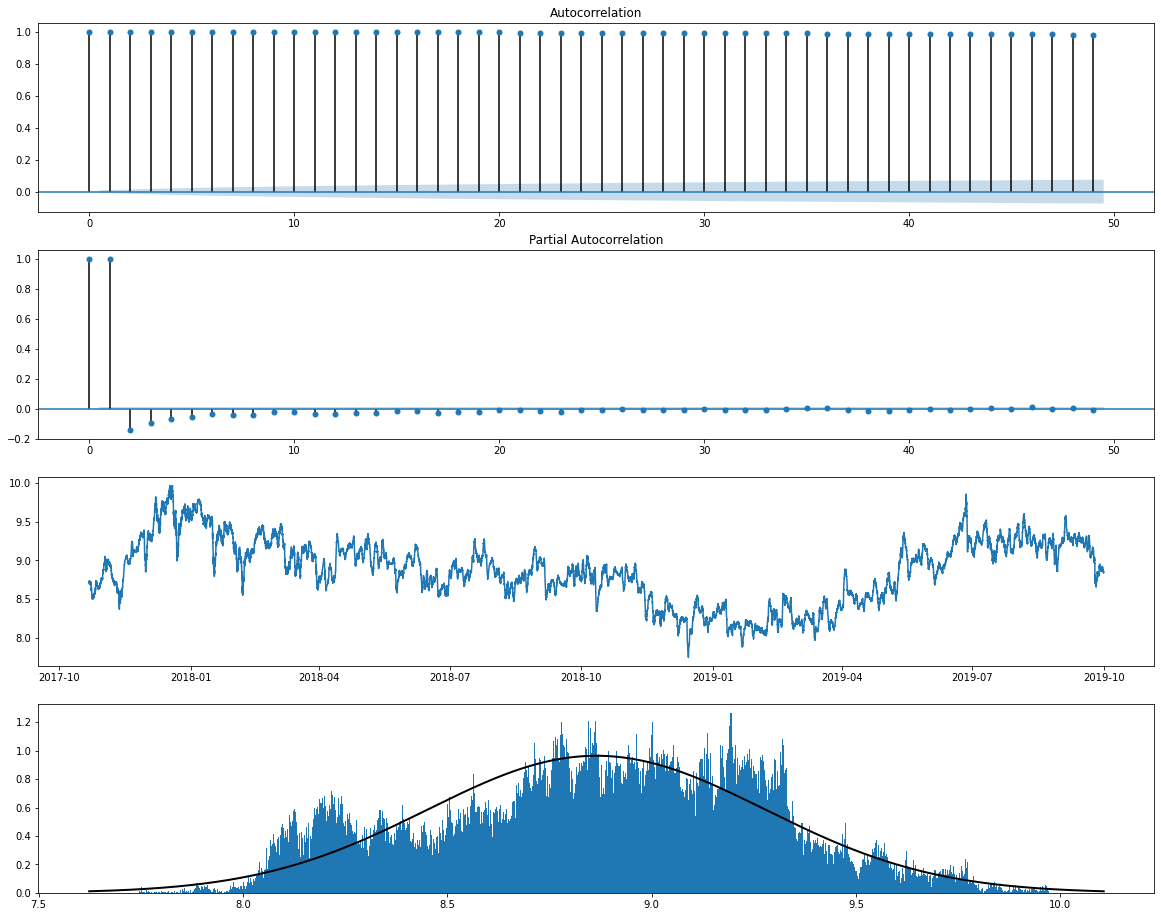

0

In [15]:
af.plot_analysis_plots(model.resid)

Does not look like there is cointegration between the raw signal and prices. 

In [0]:
BTC_df['Diff Signal'] = BTC_df['raw-score'].diff()
BTC_df = BTC_df.dropna().copy()

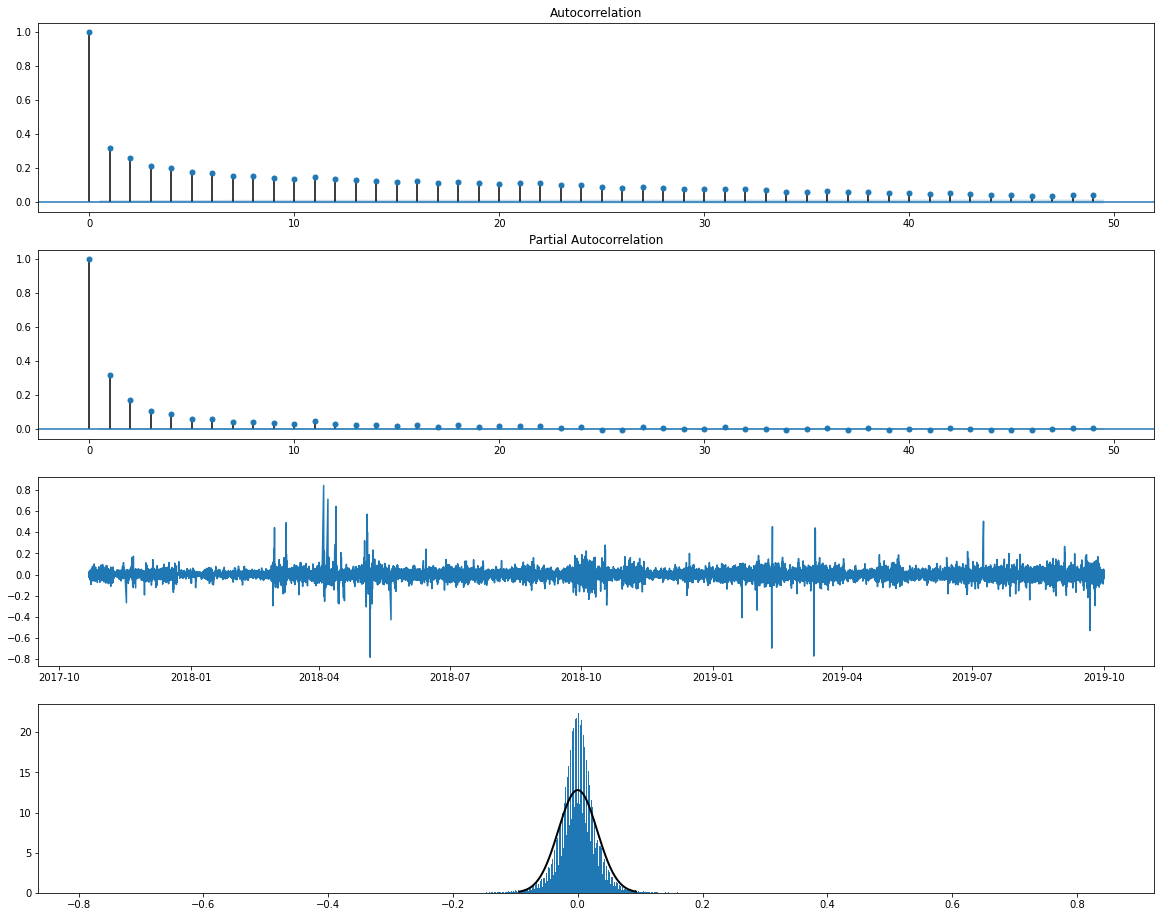

0

In [17]:
af.plot_analysis_plots(BTC_df['Diff Signal'])

In [18]:
baseline_arma = sm.tsa.ARIMA(BTC_df['Log r'], order = (1, 0, 0))
results = baseline_arma.fit(disp = -1)

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [19]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                  Log r   No. Observations:                66302
Model:                     ARMA(1, 0)   Log Likelihood              259063.392
Method:                       css-mle   S.D. of innovations              0.005
Date:                Tue, 09 Jun 2020   AIC                        -518120.784
Time:                        06:04:13   BIC                        -518093.478
Sample:                             0   HQIC                       -518112.341
                                                                              
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const        1.269e-06   1.89e-05      0.067      0.946   -3.57e-05    3.83e-05
ar.L1.Log r     0.0001      0.004      0.032      0.975      -0.007       0.008
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1         8082.2841           +0.0000j         8082.2841            0.0000
-----------------------------------------------------------------------------
"""

In [20]:
var_model = sm.tsa.VAR(BTC_df[['Log r', 'Diff Signal']]) 
results = var_model.fit(1)

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [21]:
results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 09, Jun, 2020
Time:                     06:04:14
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -17.6938
Nobs:                     66301.0    HQIC:                  -17.6944
Log likelihood:           398437.    FPE:                2.06695e-08
AIC:                     -17.6946    Det(Omega_mle):     2.06676e-08
--------------------------------------------------------------------
Results for equation Log r
                    coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------------
const                  0.000001         0.000019            0.066           0.947
L1.Log r               0.000138         0.003884            0.036           0.972
L1.Diff Signal        -0.000467         0.000606        

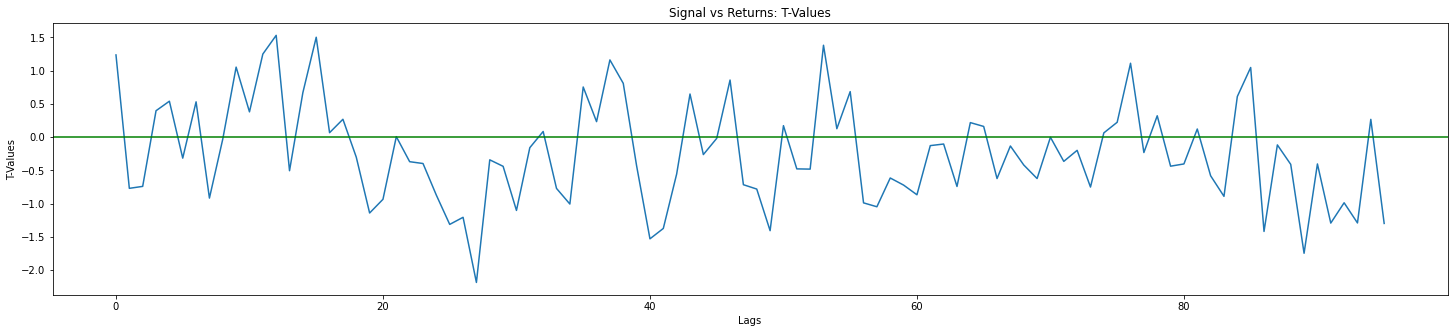

In [22]:
_, _ = af.plot_tvals2(BTC_df, 'Diff Signal', 'Log r', 0, False, 0, False, 96, True)

Doing a t-value plot with lagged regressions, it does not look like there is a clear forecastability between the differenced signal and returns

